In [1]:
import numpy as np

Kernel from pynbody, M4 from Price et al 2012

In [2]:
def kernel_M4(q, h=1):
    """Get the value of the kernel for a given smoothing length."""
    if q < 1:
        f = 1. - (3. / 2) * q ** 2 + (3. / 4.) * q ** 3
    elif q < 2:
        f = 0.25 * (2. - q) ** 3
    else:
        f = 0

    return f / (np.pi * h ** 3)

The kernel is a weighted sum of powers of $q=r/h$. Below, I will integrate each of these powers separately over the line of sight. A line-of-sight integral over a function $f(r)$ is given by
\begin{equation}
I(r_p) = 2 \int_{r_p}^\infty \frac{f(r)rdr}{\sqrt{r^2-r_p^2}} = 2h \int_{q_p}^\infty \frac{f(q)qdq}{\sqrt{q^2-q_p^2}},
\end{equation}
with $r_p$ the projected radius (the smallest distance between the line of sight and $r=0$). In the second integral, $q_p=r_p/h$.

In [3]:
def kernel(r,h):
    q = r/h
    fac = np.pi*h*h*h
    if q>2.0:
        return 0.0
    elif q>1.0:
        return (2.0 + q*(-3+q*(1.5-0.25*q)))/fac
    else: 
        return (1.0 + q*q*(0.75*q-1.5))/fac

$I0$ is the integral
\begin{equation}
\int \frac{q}{\sqrt{q^2-q_p^2}}dq
\end{equation}

In [4]:
def I0(q,qp):
    if q>qp:
        return np.sqrt(q*q-qp*qp)
    else:
        return 0.0

$I1$ is the integral
\begin{equation}
\int \frac{q^2}{\sqrt{q^2-q_p^2}}dq
\end{equation}

In [5]:
def I1(q,qp):
    if qp>0.0:
        if q>qp:
            tmp = np.sqrt(q*q-qp*qp)
            return (q*tmp + qp*qp*np.arccosh(q/qp))/2
#             return q*tmp + qp*qp*np.log(tmp + q)
        else:
            return 0.0
    else:
        return 0.5*q*q

$I2$ is the integral
\begin{equation}
\int \frac{q^3}{\sqrt{q^2-q_p^2}}dq
\end{equation}

In [6]:
def I2(q,qp):
    if q>qp:
        return (2*qp*qp+q*q)*np.sqrt(q*q-qp*qp)/3
    else:
        return 0.0

$I3$ is the integral
\begin{equation}
\int \frac{q^4}{\sqrt{q^2-q_p^2}}dq
\end{equation}

In [7]:
def I3(q,qp):
    if qp>0.0:
        if q>qp:
            tmp = np.sqrt(q*q-qp*qp)
            return (q*(3*qp*qp+2*q*q)*tmp + 3*qp**4*np.arccosh(q/qp))/8
        else:
            return 0.0
    else:
        return 0.25*q**4

In the cell below, each of these integrals is used to compose the line-of-sight integral over the kernel. 

In [8]:
def kernel2d(rp,h):
    qp = rp/h
    fac = 2/np.pi/h/h
    if qp>2.0:
        return 0.0
    elif qp>1.0:
        return ( 2*(I0(2,qp)-I0(qp,qp)) - 3*(I1(2,qp)-I1(qp,qp)) + 1.5*(I2(2,qp)-I2(qp,qp)) \
                -0.25*(I3(2,qp)-I3(qp,qp)) )*fac
    else:
        tmp1 = (I0(1,qp)-I0(qp,qp)) - 1.5*(I2(1,qp)-I2(qp,qp)) + 0.75*(I3(1,qp)-I3(qp,qp))
        tmp2 = 2*(I0(2,qp)-I0(1,qp)) - 3*(I1(2,qp)-I1(1,qp)) + 1.5*(I2(2,qp)-I2(1,qp)) \
                -0.25*(I3(2,qp)-I3(1,qp))
        return fac*(tmp1+tmp2)

### Vectorize the `pynbody` kernel

In [9]:
from pynbody.sph import Kernel, Kernel2D

kernel_M4_vec = np.vectorize(kernel_M4)

### Integrate the vectorized kernel up to the correct quantity 

In [10]:
def get_value2d(d, h=1):
    import scipy.integrate as integrate
    return 2 * integrate.quad(lambda z: kernel_M4_vec(np.sqrt(z ** 2 + d ** 2), h), 0, 2*h)[0]

class MyKernel2D(Kernel2D):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def get_value(self, d, h=1):
        return get_value2d(d,h)

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
k = Kernel()
pynbody_k2d = Kernel2D()
corrected_k2d = MyKernel2D()

In [12]:
h = 1.0
rowr = np.linspace( 0.0, 2*h, 100)
analytic_M4 = [ kernel(r,h) for r in rowr ]
analytic_M4_2D = [ kernel2d(r,h) for r in rowr ]
pynbody_M4_2D = [pynbody_k2d.get_value(r) for r in rowr]
corr_M4_2D = [corrected_k2d.get_value(r) for r in rowr]

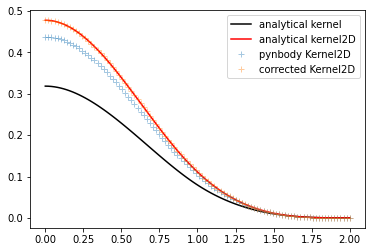

In [13]:
fig = plt.figure( )
ax  = fig.add_subplot(111)
ax.plot(rowr,analytic_M4,'k-', label='analytical kernel')
ax.plot(rowr,analytic_M4_2D,'r-', label='analytical kernel2D')
ax.plot(rowr,pynbody_M4_2D,'+', alpha=0.4, label='pynbody Kernel2D')
ax.plot(rowr,corr_M4_2D,'+', alpha=0.4, label='corrected Kernel2D')
plt.legend()
plt.show()